# Code for calculating effective dimension

In [11]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import math
import time
import qutip
import pickle


In [12]:
num_qubits=8
depth_list=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
it=20
x_sample=100
module=int(num_qubits/2)
pooling_method='NCDQML8' #NCDQML or CCDQML or QCDQML

### Circuit Blocks

In [13]:
def Haar_gate(w):
    Haar_Unitary = np.array(qutip.random_objects.rand_unitary_haar(2**len(w)))
    qml.QubitUnitary(Haar_Unitary,wires=w)
    
def Ising(weights,wires,depth): #size of circuit = number of parameter
    size=len(wires)
    if size==2: #for 2 qubit Ising, only one ZZ interaction is required.
        for d in range(depth):
            [qml.Hadamard(wires=w) for w in wires]
            [qml.RZ(weights[size*d+i],wires=wires[i]) for i in range(size)]
            qml.IsingZZ(0.5*(np.pi-weights[d*size])*(np.pi-weights[d*size+1]),wires=[wires[0],wires[1]])
    else:
        for d in range(depth):
            [qml.Hadamard(wires=w) for w in wires]
            [qml.RZ(weights[size*d+i],wires=wires[i]) for i in range(size)]
            [qml.IsingZZ(0.5*(np.pi-weights[size*d+i])*(np.pi-weights[size*d+(i+1)%size]),wires=[wires[i],wires[(i+1)%size]]) for i in range(size)]

def Convolution(weights,wires,depth): 
    size=len(wires)
    for d in range(depth):
        [qml.Hadamard(wires=w) for w in wires]
        for i in range(int(size/2)):
            qml.CZ(wires=[wires[i*2],wires[(i*2+1)%size]])
        [qml.RX(weights[size*d+i],wires=wires[i]) for i in range(size)]

        if size!=2: 
            [qml.Hadamard(wires=w) for w in wires]
            for i in range(int(size/2)):
                qml.CZ(wires=[wires[i*2+1],wires[(i*2+2)%size]])
            [qml.RX(weights[size*d+i],wires=wires[i]) for i in range(size)]



# Pooling Circuit
def Pooling(weights,m_qubit,t_qubit):
    m_f=qml.measure(m_qubit)
    qml.cond(m_f==0,qml.RZ)(weights[0],wires=t_qubit)
    qml.cond(m_f==0,qml.RX)(weights[1],wires=t_qubit)
    qml.cond(m_f==1,qml.RZ)(weights[2],wires=t_qubit)
    qml.cond(m_f==1,qml.RX)(weights[3],wires=t_qubit)

def Convolution_Pooling_CCDQML(weights,wires_1,wires_2,depth):
        qml.Barrier(wires=wires_1,only_visual=True)
        qml.Barrier(wires=wires_2,only_visual=True)
        size=len(wires_1)
        wires=[wires_1,wires_2]
        for i in range(2):
            Convolution(weights[i*depth*size:(i+1)*depth*size],wires[i],depth)
        qml.Barrier(wires=wires_1,only_visual=True)
        qml.Barrier(wires=wires_2,only_visual=True)
        poolingweights=weights[2*depth*size:]
        for j in range(int(size/2)):
            Pooling(poolingweights[8*j:8*j+4],wires_1[j*2],wires_2[j*2+1])
            Pooling(poolingweights[8*j+4:8*j+8],wires_2[j*2],wires_1[j*2+1])

    #total parameters: 2*(depth+2)*(size per module)

def Convolution_Pooling_NCDQML(weights,wires_1,wires_2,depth):
        qml.Barrier(wires=wires_1,only_visual=True)
        qml.Barrier(wires=wires_2,only_visual=True)
        size=len(wires_1)
        wires=[wires_1,wires_2]
        for i in range(2):
            Convolution(weights[i*depth*size:(i+1)*depth*size],wires[i],depth)
        poolingweights=weights[2*depth*size:]
        qml.Barrier(wires=wires_1,only_visual=True)
        qml.Barrier(wires=wires_2,only_visual=True)        
        for j in range(int(size/2)):
            Pooling(poolingweights[8*j:8*j+4],wires_1[j*2],wires_1[j*2+1])
            Pooling(poolingweights[8*j+4:8*j+8],wires_2[j*2],wires_2[j*2+1])
    #total parameters: 2*(depth+2)*(size per module)

def Convolution_Pooling_QCDQML(weights,wires,depth):
    qml.Barrier(wires=wires,only_visual=True)
    size=len(wires)
    Convolution(weights[:depth*size],wires,depth)
    qml.Barrier(wires=wires,only_visual=True)
    poolingweights=weights[depth*size:]
    for j in range(int(size/2)):
       Pooling(poolingweights[4*j:4*j+4],wires[j*2],wires[j*2+1])
    #total parameters: (depth+2)*size
    

def RandParam(num_para):
    P=[]
    for i in range(num_para):
        P.append(2*np.pi*np.random.rand())
    return np.array(P)

In [14]:
dev4=qml.device('default.qubit',wires=4)
@qml.qnode(dev4)
def circuit_22(weights):
    Haar_gate([0,1])
    Haar_gate([2,3])
    if pooling_method=='NCDQML4':
        Convolution_Pooling_NCDQML(weights,[0,1],[2,3],depth)
    if pooling_method=='CCDQML4':
        Convolution_Pooling_CCDQML(weights,[0,1],[2,3],depth)
    if pooling_method=='QCDQML4':
        Convolution_Pooling_QCDQML(weights,[0,1,2,3],depth)

    return qml.probs(wires=[1,3])

dev8=qml.device('default.qubit',wires=8)
@qml.qnode(dev8)
def circuit_44(weights):
    Haar_gate([0,1,2,3])
    Haar_gate([4,5,6,7])
    if pooling_method=='NCDQML8':
        Convolution_Pooling_NCDQML(weights[:(depth+2)*8],[0,1,2,3],[4,5,6,7],depth)
        Convolution_Pooling_NCDQML(weights[(depth+2)*8:],[1,3],[5,7],depth)
    if pooling_method=='CCDQML8':
        Convolution_Pooling_CCDQML(weights[:(depth+2)*8],[0,1,2,3],[4,5,6,7],depth)
        Convolution_Pooling_CCDQML(weights[(depth+2)*8:],[1,3],[5,7],depth)
    if pooling_method=='QCDQML8':
        Convolution_Pooling_QCDQML(weights[:(depth+2)*8],[0,1,2,3,4,5,6,7],depth)
        Convolution_Pooling_QCDQML(weights[(depth+2)*8:],[1,3,5,7],depth)
    return qml.probs(wires=[3,7])

In [15]:
depth=depth_list[0]
if num_qubits==4:
    circuit=circuit_22
if num_qubits==8:
    circuit=circuit_44

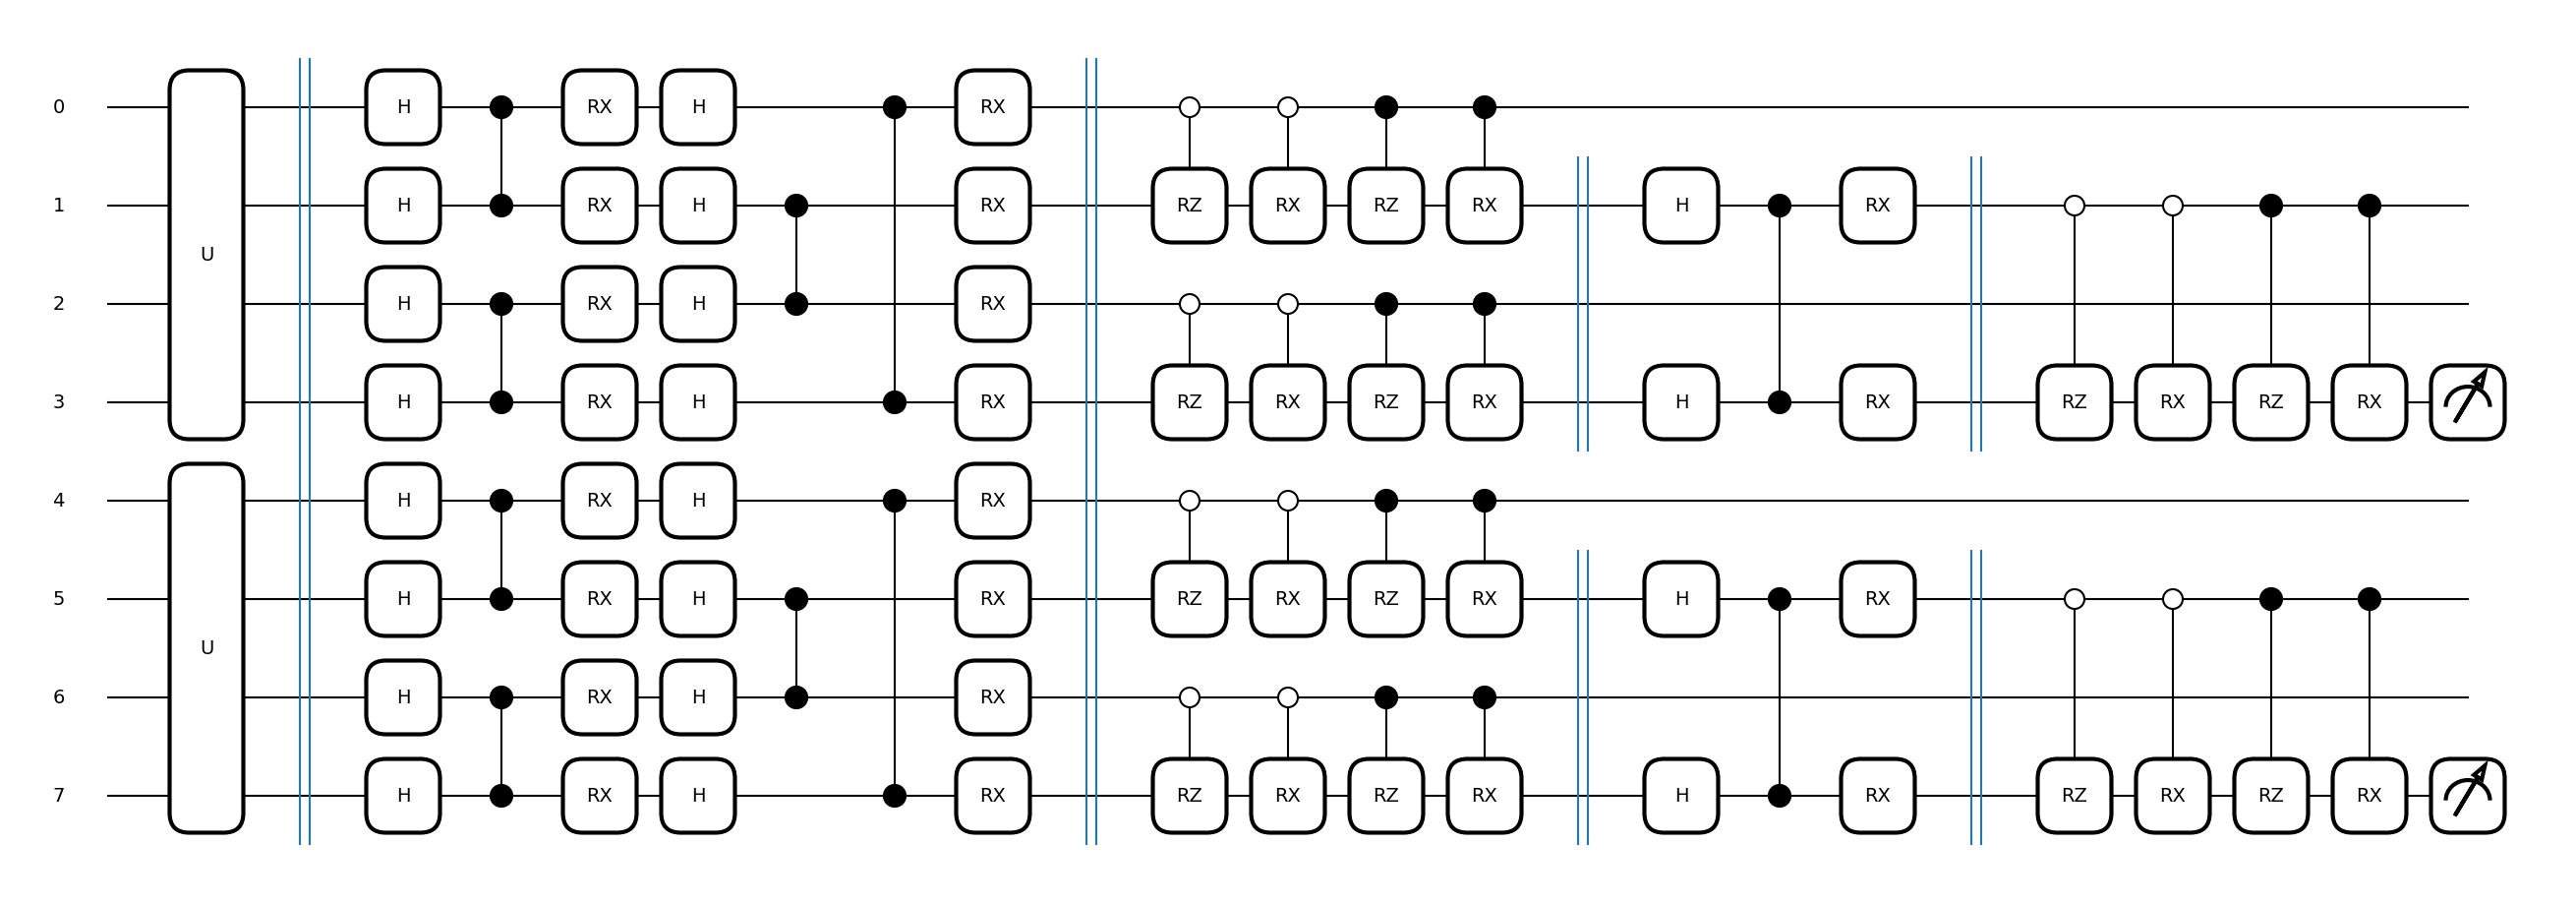

In [16]:

fig, ax =qml.draw_mpl(circuit)(RandParam(100))

In [17]:
def ParityFisherelement(dp):
    odddp=0
    evendp=0
    p_ord=[1,-1,-1,1,-1,1,1,-1,-1,1,1,-1,1,-1,-1,1]
    if len(dp)>=16:
        print('Maximum 4 measurement')
        raise ValueError
    for k in range(len(dp)):
        if p_ord[k]==1:
            evendp+=dp[k]
        else:    
            odddp+=dp[k]
    return evendp,odddp

def Fisher(weights,circuit):
    F=[]
    dp=qml.jacobian(circuit)(weights)
    p_ord=[1,-1,-1,1,-1,1,1,-1,-1,1,1,-1,1,-1,-1,1]
    p= circuit(weights)
    evenp=0
    oddp=0
    for i in range(len(p)):
        if p_ord[i]==1:
            evenp+=p[i]
        else:    
            oddp+=p[i]
    yprob=[evenp,oddp]
    for i in range(len(weights)):
        temp=[]
        for j in range(len(weights)):
            edp,odp=ParityFisherelement(dp[:,i])
            dpi=[edp,odp]
            edp,odp=ParityFisherelement(dp[:,j])
            dpj=[edp,odp]         
            temp.append(np.sum([dpi[i]*dpj[i]/(yprob[i]+1e-15) for i in range(2)]))
        F.append(temp)

    return F



In [18]:
def RandParam(num_para):
    P=[]
    for i in range(num_para):
        P.append(2*np.pi*np.random.rand())
    return np.array(P)
def Fisherinformation(depth,it,x_sample):
    if num_qubits==4:
        num_param=(depth+2)*4
    if num_qubits==8:
        num_param=(depth+2)*12
    F_list=[]
    starttime=time.time()
    for i in range (it):
        Param=RandParam(num_param)
        F_x=[]
        for j in range(x_sample):
            F_temp=Fisher(Param,circuit)
            F_x.append(F_temp)
        F_list.append(np.array(F_x))
        if i%10==0:
            donetime=time.time()
            print('iter',i+1,'done in',round(donetime-starttime,1),'sec')
    return F_list
def maxrank(FisherMatrix_list):  
    maxrank=0
    for F in FisherMatrix_list:
        rank=np.linalg.matrix_rank(F)
        if rank>maxrank:
            maxrank=rank
    return maxrank


In [19]:
def Fisher_Result(it,x_sample):
    Rank_list=[]
    global depth
    for depth in depth_list:
        starttime=time.time()
        F = Fisherinformation(depth,it,x_sample)
        F_xavg=np.mean(F,axis=1)
        r_m=maxrank(F_xavg)
        Rank_list.append(r_m)
        donetime=time.time()
        print('depth',depth,'done in',round(donetime-starttime,1),'sec')
    return Rank_list

In [20]:
R=Fisher_Result(it,x_sample)

with open('Rank_'+pooling_method, 'wb') as f:
    pickle.dump(R, f)

iter 1 done in 8.4 sec


KeyboardInterrupt: 

: 